# Import Packages and Define Functions

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier 
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IPipeline
from xgboost import XGBClassifier
from joblib import parallel_backend
import pickle
import re
from packages.model_evaluation import class_k_recall, class_k_precision, class_k_f1, class_k_acc
from packages.model_evaluation import evaluate_model

/home/joshua/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Takes in training and testing data, as well as at least one of an estimator or parameter grid
# Creates a pipeline that one-hot encodes object columns and standard scales numerical columns
# Then appends the resampling method (if applicable) and the estimator
# If grid search is specified, performs a grid search across the parameter grid, using the scoring method entered
# If no scoring method is entered, a dummy estimator is needed to establish a scoring method
# Optionally plots a confusion matrix
# Returns a fitted model
def run_model(X_train, X_test, y_train, y_test, estimator = None,
              resampling = None, grid_search = False, grid_params = None, cv = None,
              scoring = None, plot_confusion = True):
    
    # Select numeric and object columns, create preprocessing ColumnTransformer
    # After reworking the data, there are not longer any columns of object type in the data
    numeric_col = X_train.select_dtypes('number').columns.values.tolist()
#     object_col = X_train.select_dtypes('object').columns.values.tolist()
    steps_no_resampling = [('ssc', StandardScaler(), numeric_col),
#                            ('ohe', OneHotEncoder(), object_col)
                          ]
    preprocess_no_resampling = ColumnTransformer(steps_no_resampling)
    
    # Create pipeline with resambling and estimator
    steps = [('preprocess', preprocess_no_resampling), ('rsm', resampling), ('clf', estimator)]
    pipe = IPipeline(steps = steps)
    
    # If grid_search is input, create a grid search using the entered grid_params
    # Else, just use above pipeline
    if grid_search:
        model = GridSearchCV(pipe, param_grid = grid_params, cv = cv, scoring = scoring)
    else:
        model = pipe
    
    # Fit the model using multi-threading - uses all cpu cores
    with parallel_backend('threading', n_jobs = -1):
        model.fit(X_train, y_train)
    
    # Plots confusion matrix
    if plot_confusion:
        ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test))).plot();
        
    return model

# Import Dataframes

In [3]:
# Import dataframes and split into train and test values, as well as X and y values
train_multi = pd.read_parquet('../data/cleaned/train_multi.parquet')
X_train_multi = train_multi.drop('classification', axis = 1)
y_train_multi = train_multi.classification
test_multi = pd.read_parquet('../data/cleaned/test_multi.parquet')
X_test_multi = test_multi.drop('classification', axis = 1)
y_test_multi = test_multi.classification

train_binary = pd.read_parquet('../data/cleaned/train_binary.parquet')
X_train_binary = train_binary.drop('disposition', axis = 1)
y_train_binary = train_binary.disposition
test_binary = pd.read_parquet('../data/cleaned/test_binary.parquet')
X_test_binary = test_binary.drop('disposition', axis = 1)
y_test_binary = test_binary.disposition

# Inspect Class Imbalances and Create Sampling Options

In [4]:
# Severe class imbalance in multi-class dataset, will need to use resampling methods
y_train_multi.value_counts()

0    1942
2     814
3     299
1     282
4      71
Name: classification, dtype: int64

In [5]:
# Classes are mostly balanced in binary class dataset, resampling probably not needed
y_train_binary.value_counts()

1    2350
0    1942
Name: disposition, dtype: int64

In [6]:
# Test SMOTE and RandomOverSampler, as there is not enough data to use RandomUnderSampler
samplers = [(SMOTE(random_state = 42, n_jobs = -1)),
            (RandomOverSampler(random_state = 42))]

# Binary Class Models

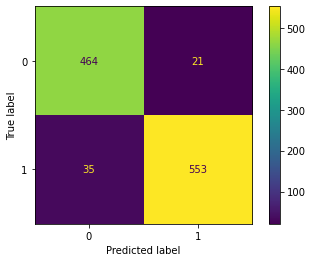

In [7]:
# Baseline logistic regression model
base_logistic_pipe = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                               estimator = LogisticRegression(random_state = 42, max_iter = 1000),
                               plot_confusion = True)

# with open('../data/models/binary/binary_base_logistic.pickle', 'wb') as f:
#     pickle.dump(base_logistic_pipe, f)

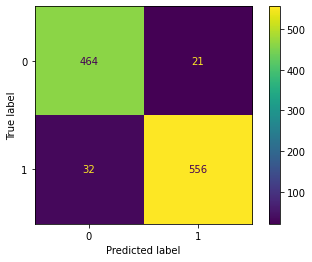

In [7]:
# Hyperparameter-tuned logistic regression
params = [
    {
        'clf': (LogisticRegression(random_state = 42, max_iter = 5000),),
        'clf__C': [1e-4, 1e-3, 1e-2, 1, 1e2, 1e3, 1e4],
    }
]

logistic = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                     grid_search = True, grid_params = params, estimator = LogisticRegression(),
                     plot_confusion = True)

# with open('../data/models/binary/binary_logistic.pickle', 'wb') as f:
#     pickle.dump(logistic, f)

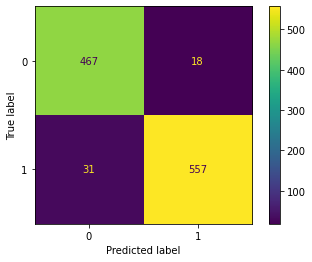

In [8]:
# Tuned decision tree model
params = [
    {
        'clf': (DecisionTreeClassifier(random_state = 42),),
        'clf__max_depth': [5, 7, 9, 11, 13],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_features': ['sqrt', None]
    }
]

tree = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                 grid_search = True, grid_params = params, estimator = DecisionTreeClassifier(),
                 plot_confusion = True)

# with open('../data/models/binary/binary_tree.pickle', 'wb') as f:
#     pickle.dump(tree, f)

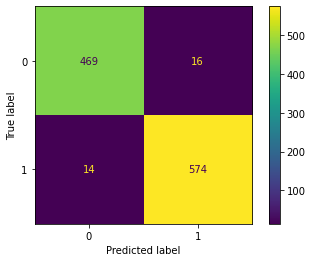

In [9]:
# Tuned Random Forest model
# Max depth impacts the strength of each learner - had more success using stronger learners (default 1)
# Grid Search minimal due to computation requirements
params = [
    {
        'clf': (RandomForestClassifier(random_state = 42),),
        'clf__n_estimators': [100, 300],
        'clf__max_depth': [5, 7, 9]
#         'rsm': samplers
    }
]

random_forest = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                          estimator = RandomForestClassifier(),
                          grid_search = True, grid_params = params, scoring = None,
                          cv = 5, plot_confusion = True)

# with open('../data/models/binary/binary_random_forest.pickle', 'wb') as f:
#     pickle.dump(random_forest, f)

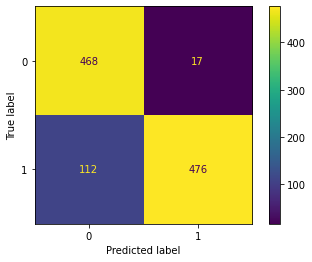

In [10]:
# Tuned K-Nearest Neighbors model
params = [
    {
        'clf': (KNeighborsClassifier(),),
        'clf__n_neighbors': [3, 5, 7, 9, 11, 13],
        'rsm': samplers
    }
]

kneighbors = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                       estimator = KNeighborsClassifier(),
                       grid_search = True, grid_params = params,
                       cv = 5, plot_confusion = True)

# with open('../data/models/binary/binary_kneighbors.pickle', 'wb') as f:
#     pickle.dump(kneighbors, f)

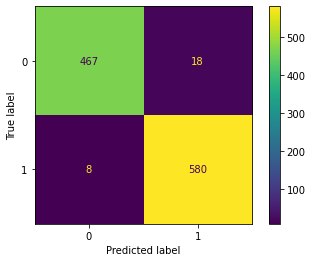

In [11]:
# Tuned AdaBoost Tree Classifier
# Testing with various weak base estimators, as well as number of estimators and learning rate
# Grid Search minimal due to computation requirements
params = [
    {
        'clf': (AdaBoostClassifier(random_state = 42),),
        'clf__base_estimator': [DecisionTreeClassifier(random_state = 42, max_depth = 1),
                           DecisionTreeClassifier(random_state = 42, max_depth = 2)],
        'clf__n_estimators': [100, 200, 300, 400, 500],
        'clf__learning_rate': [0.1, 1],
#         'rsm': samplers
    }
]

adaboost = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                     estimator = AdaBoostClassifier(),
                     grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

# with open('../data/models/binary/binary_adaboost.pickle', 'wb') as f:
#     pickle.dump(adaboost, f)

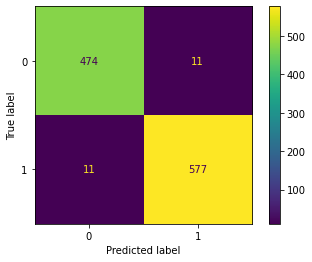

In [12]:
# Tuned Gradient Boosting Tree Classifier
# Gradient Boosting resilient to overfitting, so number of estimators increased (default 100)
# Tested using subset of features
# Grid Search minimal due to computation requirements
params = [
    {
        'clf': (GradientBoostingClassifier(random_state = 42),),
        'clf__n_estimators': [100, 500, 1000],
        'clf__max_features': [None, 'sqrt'],
        'clf__max_depth': [2, 3]
#         'rsm': samplers
    }
]

gradientboost = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                     estimator = GradientBoostingClassifier(),
                     grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

# with open('../data/models/binary/binary_gradientboost.pickle', 'wb') as f:
#     pickle.dump(gradientboost, f)

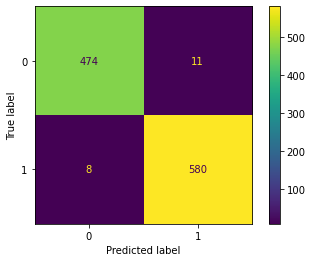

In [8]:
# Tuned XG Boost Tree Classifier
# Scored on accuracy
# Stronger estimators performed better (default max_depth = 6)
# Grid Search minimal due to computation requirements
params = [
    {
        'clf': (XGBClassifier(random_state = 42),),
        'clf__n_estimators': [100, 500, 1000],
        'clf__max_depth': [6, 9, 12],
#         'rsm': samplers
    }
]

xgboost = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                     estimator = XGBClassifier(), grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

# with open('../data/models/binary/binary_xgboost.pickle', 'wb') as f:
#     pickle.dump(xgboost, f)

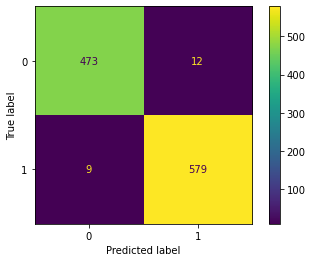

In [9]:
# Testing a tuned XG Boost Tree Classifier using class 0 recall as scoring metric
# Ideally, we want to maximize the number of confirmed planets correctly identified
# Even at the expense of some false positives being confirmed as planets
# Appears to have performed relatively similarly - differences likely due to stochasticity
params = [
    {
        'clf': (XGBClassifier(random_state = 42),),
        'clf__n_estimators': [1000],
        'clf__max_depth': [9, 12, None],
#         'rsm': samplers
    }
]

xgboost_class_0_recall = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                                   grid_search = True, grid_params = params,
                                   scoring = make_scorer(class_k_recall, k = 0), cv = 5, plot_confusion = True)

# with open('../data/models/binary/binary_xgboost_class_0_recall.pickle', 'wb') as f:
#     pickle.dump(xgboost_class_0_recall, f)

# Multiclass Models

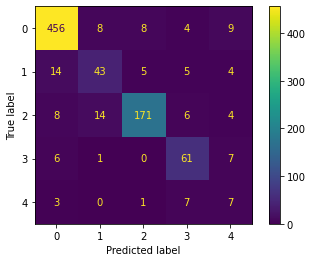

In [13]:
# Base decision tree classifier without resampling
base_decision_tree = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     estimator = DecisionTreeClassifier(random_state = 42), plot_confusion = True)

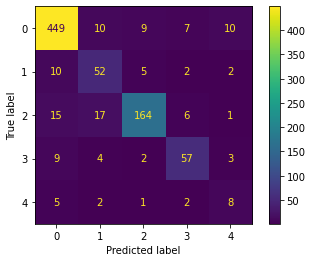

In [10]:
# Base decision tree classifier with resampling
# Resampling needed for multi-class dataset due to class imbalance
params = [
    {
        'clf': (DecisionTreeClassifier(random_state = 42),),
        'rsm': samplers
    }
]

base_tree_sampling = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                               estimator = DecisionTreeClassifier(), grid_search = True, grid_params = params,
                               cv = 5, plot_confusion = True)

# with open('../data/models/multi/multi_base_tree.pickle', 'wb') as f:
#     pickle.dump(base_tree_sampling, f)

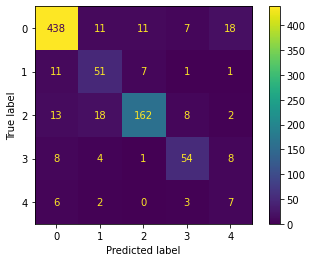

In [14]:
# Tuned decision tree classifier
params = [
    {
        'clf': (DecisionTreeClassifier(random_state = 42),),
        'clf__max_depth': [5, 7, 9, 11, 13],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_features': ['sqrt', None],
        'rsm': samplers
    }
]

tree = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                 estimator = DecisionTreeClassifier(), grid_search = True, grid_params = params,
                 cv = 5, plot_confusion = True)

# with open('../data/models/multi/multi_tree.pickle', 'wb') as f:
#     pickle.dump(tree, f)

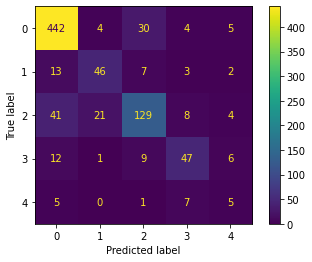

In [15]:
# Tuned K-Nearest Neighbors Classifier
params = [
    {
        'clf': (KNeighborsClassifier(),),
        'clf__n_neighbors': [3, 5, 7, 9],
        'clf__weights': ['uniform', 'distance'],
        'rsm': samplers
    }
]

kneighbors = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                 estimator = KNeighborsClassifier(), grid_search = True, grid_params = params,
                 cv = 5, plot_confusion = True)

# with open('../data/models/multi/multi_kneighbors.pickle', 'wb') as f:
#     pickle.dump(kneighbors, f)

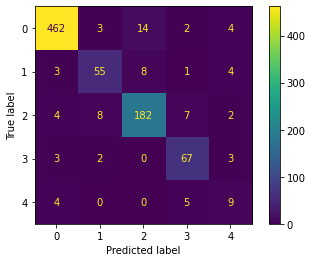

In [16]:
# Tuned Random Forest Classifier
# Resampling with such large class imbalances is very computationally expensive
# Grid Search limited due to computational difficulties
params = [
    {
        'clf': (RandomForestClassifier(random_state = 42),),
        'clf__n_estimators': [100, 300],
        'clf__max_depth': [5, 7, 9],
        'rsm': samplers
    }
]

random_forest = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                          estimator = RandomForestClassifier(),
                          grid_search = True, grid_params = params, scoring = None,
                          cv = 5, plot_confusion = True)

# with open('../data/models/multi/multi_random_forest.pickle', 'wb') as f:
#     pickle.dump(random_forest, f)

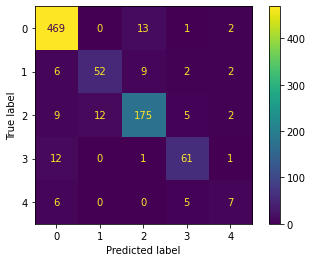

In [17]:
# Tuned AdaBoost Tree Classifier
# Tested various weak learners
# Grid Search limited due to computational difficulties
params = [
    {
        'clf': (AdaBoostClassifier(random_state = 42),),
        'clf__base_estimator': [DecisionTreeClassifier(random_state = 42, max_depth = 1),
                                DecisionTreeClassifier(random_state = 42, max_depth = 2),
                                DecisionTreeClassifier(random_state = 42, max_depth = 3)],
        'clf__n_estimators': [100, 300, 500],
        'rsm': samplers
    }
]

adaboost = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     estimator = AdaBoostClassifier(),
                     grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

# with open('../data/models/multi/multi_adaboost.pickle', 'wb') as f:
#     pickle.dump(adaboost, f)

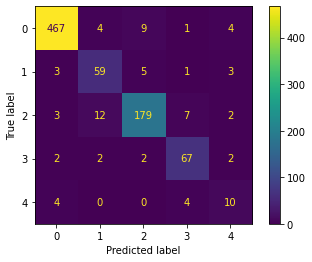

In [18]:
# Tuned Gradient Boosting Tree Classifier
# Grid Search very limited due to computational difficulties
params = [
    {
        'clf': (GradientBoostingClassifier(random_state = 42),),
#         'clf__n_estimators': [100, 500],
        'clf__max_features': [None, 'sqrt'],
        'clf__max_depth': [2, 3],
        'rsm': samplers
    }
]

gradientboost = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     estimator = GradientBoostingClassifier(),
                     grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

# with open('../data/models/multi/multi_gradientboost.pickle', 'wb') as f:
#     pickle.dump(gradientboost, f)

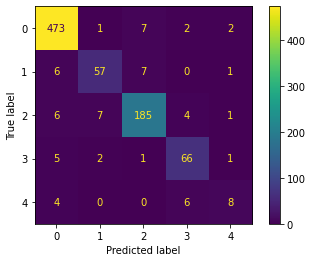

In [11]:
# Tuned XG Boost Tree Classifier
# Grid Search very limited due to computational difficulties
params = [
    {
        'clf': (XGBClassifier(random_state = 42),),
        'clf__n_estimators': [1000],
        'clf__max_depth': [6, 12],
        'clf__colsample_bynode': [0.5, 1],
        'rsm': samplers
    }
]

xgboost = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     estimator = XGBClassifier(), grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

# with open('../data/models/multi/multi_xgboost.pickle', 'wb') as f:
#     pickle.dump(xgboost, f)

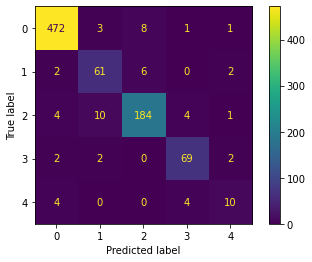

In [13]:
# Testing a tuned XG Boost Tree Classifier using class 0 recall as scoring metric
# Appears to have performed relatively similarly
# Minor increase in class 3 and class 4 identification at the expense of class 2 identification
# Grid Search very limited due to computational difficulties and lack of time
params = [
    {
        'clf': (XGBClassifier(random_state = 42),),
        'clf__n_estimators': [500],
        'clf__max_depth': [3, 6],
        'clf__colsample_bynode': [0.25, 0.5],
        'rsm': [samplers[-2]]
    }
]

xgboost_class_0_recall = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     grid_search = True, grid_params = params, scoring = make_scorer(class_k_recall, k = 0),
                     cv = 3, plot_confusion = True)

# with open('../data/models/multi/multi_xgboost_class_0_recall.pickle', 'wb') as f:
#     pickle.dump(xgboost_class_0_recall, f)

# Model Analysis

In [14]:
# Inspecting baseline binary logistic model
with open('../data/models/binary/binary_base_logistic.pickle', 'rb') as f:
    base_binary_model = pickle.load(f)

base_binary_class_report, base_binary_features = evaluate_model(X_test_binary, y_test_binary, base_binary_model)
base_binary_class_report

,recall,precision,f1,accuracy,auc
0,0.956701,0.929860,0.943089,0.94781,0.986426
1,0.940476,0.963415,0.951807,NaN,NaN


In [15]:
base_binary_features.coefficient = base_binary_features.coefficient.abs()
base_binary_features.nlargest(15, 'coefficient')

,feature,coefficient
26,planet_star_radius_ratio,5.263402
44,angular_offset_sky,5.225884
24,transit_depth,2.839433
12,max_single_event_stat,2.317015
29,planet_temp,1.783650
22,impact,1.745838
23,transit_duration,1.674345
13,max_multi_event_stat,1.527289
30,star_temp,1.496159
27,planet_star_distance_radius,1.408665


In [16]:
# Inspecting final xgboost (accuracy scoring) binary model
with open('../data/models/binary/binary_xgboost.pickle', 'rb') as f:
    best_binary_model = pickle.load(f)

best_binary_class_report, best_binary_features = evaluate_model(X_test_binary, y_test_binary, best_binary_model)
best_binary_class_report

,recall,precision,f1,accuracy,auc
0,0.977320,0.983402,0.980352,0.982293,0.995866
1,0.986395,0.981387,0.983885,NaN,NaN


In [17]:
best_binary_features.coefficient = best_binary_features.coefficient.abs()
best_binary_features.nlargest(15, 'coefficient')

,feature,coefficient
35,flux_weight_offset_sig,0.370366
20,planet_radius_earth,0.131406
0,num_of_objects_around_star,0.093754
13,max_multi_event_stat,0.074179
44,angular_offset_sky,0.069527
27,planet_star_distance_radius,0.050094
26,planet_star_radius_ratio,0.028632
29,planet_temp,0.011607
32,star_metallicity,0.009010
46,star_density,0.008322


In [18]:
# Inspecting baseline tree multi-class model
with open('../data/models/multi/multi_base_tree.pickle', 'rb') as f:
    base_multi_model = pickle.load(f)

base_multi_class_report, base_multi_features = evaluate_model(X_test_multi, y_test_multi, base_multi_model)
base_multi_class_report

,recall,precision,f1,accuracy,auc
0,0.925773,0.920082,0.922919,0.856808,0.854234
1,0.732394,0.611765,0.666667,NaN,NaN
2,0.807882,0.906077,0.854167,NaN,NaN
3,0.760000,0.770270,0.765101,NaN,NaN
4,0.444444,0.333333,0.380952,NaN,NaN


In [19]:
base_multi_features.coefficient = base_multi_features.coefficient.abs()
base_multi_features.nlargest(15, 'coefficient')

,feature,coefficient
13,max_multi_event_stat,0.247310
44,angular_offset_sky,0.177385
26,planet_star_radius_ratio,0.085125
20,planet_radius_earth,0.068747
35,flux_weight_offset_sig,0.053760
23,transit_duration,0.039313
27,planet_star_distance_radius,0.027260
24,transit_depth,0.021819
21,orbit_semimajor_axis,0.017938
46,star_density,0.017581


In [20]:
# Inspecting final xgboost (accuracy scoring) multi-class model
with open('../data/models/multi/multi_xgboost.pickle', 'rb') as f:
    best_multi_model = pickle.load(f)

best_multi_class_report, best_multi_features = evaluate_model(X_test_multi, y_test_multi, best_multi_model)
best_multi_class_report

,recall,precision,f1,accuracy,auc
0,0.975258,0.957490,0.966292,0.926056,0.982354
1,0.802817,0.850746,0.826087,NaN,NaN
2,0.911330,0.925000,0.918114,NaN,NaN
3,0.880000,0.846154,0.862745,NaN,NaN
4,0.444444,0.615385,0.516129,NaN,NaN


In [21]:
best_multi_features.coefficient = best_multi_features.coefficient.abs()
best_multi_features.nlargest(15, 'coefficient')

,feature,coefficient
0,num_of_objects_around_star,0.168226
44,angular_offset_sky,0.071962
21,orbit_semimajor_axis,0.061882
24,transit_depth,0.057739
13,max_multi_event_stat,0.045450
26,planet_star_radius_ratio,0.044158
35,flux_weight_offset_sig,0.043328
12,max_single_event_stat,0.038659
25,orbital_period,0.027999
10,kepler_band_mag,0.027329
